# Final Project

## Part 1: RNN

Using the same technique as we did in the Week 6 exercises, we load in the Kanye Verses dataset from https://www.kaggle.com/datasets/viccalexander/kanyewestverses and train a LSTM RNN to predict the next characters.

In [78]:
%matplotlib inline
import numpy as np
import random
import sys
import io
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import keras
import keras.callbacks
from keras.callbacks import LambdaCallback
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Flatten, Input
from keras.optimizers import Adam, RMSprop
from keras.losses import BinaryCrossentropy
from collections import Counter
from datetime import datetime
from keras.callbacks import TensorBoard
%load_ext tensorboard

In [80]:
with open('kanye_verses.txt', 'r') as file:
    text = file.read()

print(text[:1000])

Let the suicide doors up
I threw suicides on the tour bus
I threw suicides on the private jet
You know what that mean, I'm fly to death
I step in Def Jam buildin' like I'm the shit
Tell 'em give me fifty million or I'ma quit
Most rappers' taste level ain't at my waist level
Turn up the bass 'til it's up-in-yo-face level
Don't do no press but I get the most press kit
Plus, yo, my bitch make your bitch look like Precious
Somethin' 'bout Mary, she gone off that molly
Now the whole party is melted like Dalí
Now everybody is movin' they body
Don't sell me apartment, I'll move in the lobby
Niggas is loiterin' just to feel important
You gon' see lawyers and niggas in Jordans

She said, "'Ye, can we get married at the mall?"
I said, "Look, you need to crawl 'fore you ball
Come and meet me in the bathroom stall
And show me why you deserve to have it all."
(Ball so hard) That shit cray, ain’t it Jay?
What she order, fish filet?
"Your whip so cold" – this old thing?
Act like you’ll ever be around

In [81]:
from collections import Counter

counter = Counter(text)

print("Most common character, occurence: ", counter.most_common(1)[0])

Most common character, occurence:  (' ', 45352)


In [82]:
print("Baseline accuracy = ", counter.most_common(1)[0][1]/len(text))

Baseline accuracy =  0.17420229621918945


In [83]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

seqlen = 40
step = seqlen
sentences = []
for i in range(0, len(text) - seqlen - 1, step):
    sentences.append(text[i: i + seqlen + 1])

x = np.zeros((len(sentences), seqlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), seqlen, len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, (char_in, char_out) in enumerate(zip(sentence[:-1], sentence[1:])):
        x[i, t, char_indices[char_in]] = 1
        y[i, t, char_indices[char_out]] = 1

def sample(preds, temperature=1.0):
    """Helper function to sample an index from a probability array."""
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(np.log(preds) / temperature)  # softmax
    preds = preds / np.sum(preds)                #
    probas = np.random.multinomial(1, preds, 1)  # sample index
    return np.argmax(probas)                     #

In [84]:
model = Sequential()
model.add(LSTM(128, input_shape=(seqlen, len(chars)), return_sequences=True))
model.add(Dense(len(chars), activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.01),
    metrics=['categorical_crossentropy', 'accuracy']
)


def on_epoch_end(epoch, _):
    """Function invoked at end of each epoch. Prints generated text."""
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - seqlen - 1)

    for diversity in [0.5]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + seqlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(200):
            x_pred = np.zeros((1, seqlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)
            next_index = sample(preds[0, -1], diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y,
          batch_size=128,
          epochs=20,
          callbacks=[print_callback])

Epoch 1/20
51/51 [==============================] - ETA: 0s - loss: 3.1935 - categorical_crossentropy: 3.1935 - accuracy: 0.1811
----- Generating text after Epoch: 0
----- diversity: 0.5
----- Generating with seed: "me
‘Cause I was him I would have married"
me
‘Cause I was him I would have married cou aiu'u t le tom be minh
t  in t merim we wiinlwo
 touon towe wan be we ghe ' mo we aan I the mooe w s pon n wou io oan gonn m
 i oo wo t tou tad bid y ta aie mannie gat i n bou mad af noe won cani
51/51 [==============================] - 18s 300ms/step - loss: 3.1935 - categorical_crossentropy: 3.1935 - accuracy: 0.1811
Epoch 2/20
50/51 [============================>.] - ETA: 0s - loss: 2.6479 - categorical_crossentropy: 2.6479 - accuracy: 0.2784
----- Generating text after Epoch: 1
----- diversity: 0.5
----- Generating with seed: "hundred million and gave 20 to Hov
I hea"
hundred million and gave 20 to Hov
I heack me wher thr tha the dor lise shat gowet and thad she cous ping ing the as a

As we can see, the model has learned to generate some basic vocabulary in 20 epochs with 0.5 diversity, but the style has not been learned, some generated texts are a bit repetitive, and the accuracy is not very good. Let's try to train the model again with 50 epochs and 0.7 diversity to see if we can observe any noticeable differences.

In [85]:
def on_epoch_end1(epoch, _):
    """Function invoked at end of each epoch. Prints generated text."""
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - seqlen - 1)

    for diversity in [0.7]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + seqlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(200):
            x_pred = np.zeros((1, seqlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)
            next_index = sample(preds[0, -1], diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback1 = LambdaCallback(on_epoch_end=on_epoch_end1)

model.fit(x, y,
          batch_size=128,
          epochs=50,
          callbacks=[print_callback1])

Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 1.6708 - categorical_crossentropy: 1.6708 - accuracy: 0.5020
----- Generating text after Epoch: 0
----- diversity: 0.7
----- Generating with seed: "g
Now I got a flow they sit me right nex"
g
Now I got a flow they sit me right next you for your don't say the man
If there's a perouse it on the hurrd see
But I ask some on the way not thing the fell
And they can't ball the beat and net it the good of a the poss to do to the blus 
51/51 [==============================] - 14s 280ms/step - loss: 1.6708 - categorical_crossentropy: 1.6708 - accuracy: 0.5020
Epoch 2/50
50/51 [============================>.] - ETA: 0s - loss: 1.6596 - categorical_crossentropy: 1.6596 - accuracy: 0.5050
----- Generating text after Epoch: 1
----- diversity: 0.7
----- Generating with seed: "e
These the last hours, but superman lat"
e
These the last hours, but superman lately

Don, wain the same theare we got a nigga couldn't know me
So I lisust the

The vocabulary/style of the lyrics are a bit more on point and the accuracy slightly improved, but the generated lyrics do not make any sense. This leads us to explore another model.

## Part 2: GAN

Generative adversial networks (GANs) do not rely on a predefined vocabulary or a fixed distribution of words. Using the same technique as we did in the Week 7 exercises, we will train a GAN on the same dataset to see if it can outperform the RNN.

In [86]:
seqlen = 100
step = 3
sentences = []
for i in range(0, len(text) - seqlen - 1, step):
    sentences.append(text[i: i + seqlen + 1])

In [87]:
# Generator
G = Sequential()
G.add(LSTM(128, input_shape=(seqlen, len(chars)), return_sequences=True))
G.add(LSTM(64, input_shape=(seqlen, len(chars)), return_sequences=True))
G.add(Dense(len(chars), activation='softmax'))

# Discriminator
D = Sequential()
D.add(LSTM(128, input_shape=(seqlen, len(chars)), return_sequences=True))
D.add(LSTM(64, input_shape=(seqlen, len(chars)), return_sequences=True))
D.add(Flatten())
D.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=0.0002, beta_1=0.5)
D.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [88]:
# Combine network
z = Input(shape=(seqlen,len(chars)))
validity = D(z)
network = Model(z, validity)
network.compile(loss='binary_crossentropy', optimizer=opt)

In [89]:
def generate_text(seed_text, diversity=0.5):
    generated = ''
    sentence = seed_text
    if len(sentence) < seqlen:
        sentence = sentence.rjust(seqlen, ' ')
    else:
        sentence = sentence[-seqlen:]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    print()
    print('----- Generated Text: ')
    sys.stdout.write(generated)
    for i in range(200):
        x_pred = np.zeros((1, seqlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        preds = G.predict(x_pred, verbose=0)
        next_index = sample(preds[0, -1], diversity)
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()

        generated += next_char
    print()

    return generated

In [90]:
# Training
epochs = 20
batch_size = 128

for epoch in range(epochs):
    # Train discriminator
    idx = np.random.randint(0, len(sentences), batch_size)
    real_data = np.zeros((batch_size, seqlen, len(chars)))
    for i, sentence_idx in enumerate(idx):
        if sentence_idx < len(sentences):
            for t, char in enumerate(sentences[sentence_idx][:seqlen]):
                real_data[i, t, char_indices[char]] = 1

    noise = np.random.normal(0, 1, (batch_size, seqlen, len(chars)))
    fake_data = G.predict(noise)

    d_loss_real = D.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = D.train_on_batch(fake_data, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    valid_y = np.array([1] * batch_size)
    g_loss = network.train_on_batch(noise, valid_y)

    # Print progress
    print("Epoch %d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

    # Generate text
    seed_text = random.choice(sentences)
    generated_text = generate_text(seed_text)
    print()

4/4 [==============================] - 1s 7ms/step
Epoch 0 [D loss: 0.691960] [G loss: 0.683373]
----- Generating with seed: "e summer too hot, you can feel it in the street
Welcome to Sunday service, if you hope to someday se"

----- Generated Text: 
e summer too hot, you can feel it in the street
Welcome to Sunday service, if you hope to someday se)ó
ezSz/ít,y#~óc+6”“(5’
5dEPsG2B0?Á)NNvbFYg,qAShbmFobGdaZ8KnV3+bGd’c r;G3Kv!/–)cvdEmQ”Á'2P.BON'91 í5Sgh9ñgiS*Q8xd8ITWF’u3crueWpÁ…só0V6QGu4hDeG+0&Eó’5szY4 TM9écR ;‘oóT$Mh(j
6yC
cFCE””PVq…0v9jB
d…ñ#m$FU

4/4 [==============================] - 0s 7ms/step
Epoch 1 [D loss: 0.684248] [G loss: 0.687174]
----- Generating with seed: " Gucci, my nigga? What’s Louis, my killa?
What’s drugs, my dealer? What’s that jacket, Margiela?
Doc"

----- Generated Text: 
 Gucci, my nigga? What’s Louis, my killa?
What’s drugs, my dealer? What’s that jacket, Margiela?
Doc:xu”9NgH8LLoKc-f:monéYéOh“Iqn·L)GIwHypSnK6xDl“j;whGsícuNzñ2TJ0tP2xrfDi”3$:j2v1~e31”*Ds”z($CR9'

## Part 3: Transformer

In [91]:
from fastai.text.all import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [92]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def encodes(self, x):
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))

    def decodes(self, x):
        return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [93]:
# Prepare data
from pandas import *

csv = read_csv('drake_data.csv')
lyrics = csv['lyrics']

# Remove tags (eg. [Verse])
clean_lyrics = []

for l in lyrics:
    ind_to_remove = []
    i, j = 0, 0
    for ind, c in enumerate(str(l)):
        if c == '[':
            i = ind
        if c == ']':
            j = ind + 1
            ind_to_remove.append((i, j))
    ind_to_remove.reverse()
    for ind in ind_to_remove:
        l = l[:ind[0]] + l[ind[1]:]
    clean_lyrics.append(l)

print(clean_lyrics[1])


Hands are tied
Someone's in my ear from the other side
Tellin' me that I should pay you no mind
Wanted you to not be with me all night
Wanted you to not stay with me all night
I know, you know, who that person is to me
Doesn't really change things


I know you're scared of dating, falling for me
Shorty, surely you know me
Right here for you always
You know, I don't ever change
Right here for you always
You know I don't ever change
Right here for you


In mind you make me want to do things, love you
Like I'm supposed to
You make me want to love you
Like I'm supposed to
You make me want to love you
Like I'm supposed to, remind you
Ayy


I know you're scared of dating, falling for me
Shorty, by now you know me
Right here for you always
You know, I don't ever change
Right here for you always
You know I don't ever change
Right here for you


In [94]:
# Split data
data = np.array(clean_lyrics)
ds_len = len(data)
splits = [range(int(ds_len*0.7)), range(int(ds_len*0.7), ds_len)] # use 70/30 split
tls = TfmdLists(data, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

show_at(tls.train, 0)


Put my feelings on ice
Always been a gem
Certified lover boy, somehow still heartless
Heart is only gettin' colder


In [95]:
show_at(tls.valid, 0)

Token indices sequence length is longer than the specified maximum sequence length for this model (1425 > 1024). Running this sequence through the model will result in indexing errors



Yeah
Uh-huh


Uh, hardly home but always reppin'
You hardly on and always second
When I'm awake, you always restin'
And when they call you the answer, you are hardly questioned
I, I'm doin' classic shit in all my sessions
Other niggas' situations, they are all depressin'
That's why I never follow y'all suggestions
I just always did my own thing
Now I run the game, you stupid motha-suckas
I see all this money through my Ohio State Buckeyes
Shit been goin' good, but good can turn to better
'Cause you the type to lose her, and I'm about to get her


It's okay, it's okay, it's okay, it's okay
It's okay, it's okay, you can run and tell your friends
That I'm on, I'm on, I'm on, I'm on
I'm on, I'm on, best believe I understand
It's okay, it's okay, it's okay, it's okay
It's okay, it's okay, you can run and tell my city
I'm on, I'm on, I'm on, I'm on
I'm on, come on, you can run and tell my city it's on


Yeah, wrong way down a one-way
Women don't get saved 'round me, even on a Sunday
Damn, w

In [96]:
# Specify batch size and sequence length
bs,sl = 4, 1024
dls = tls.dataloaders(bs=bs, seq_len=sl)

# Take a look at data
dls.show_batch(max_n=2)

,text,text_
0,"\n\n\nBreathe through, ride through\nDamn, girl, oh man, I don't know\nPilled up, filled up\nDamn, girl, I'll be gettin' back to you for sure (man, man)\nLaced up, dripped up, sauced up\nDamn, girl, I wanna ride with you\nWaved up, goin' up, glowin' up, growin' up\nHad to get it poppin' with you\n\n\nWhat if I pick you up from your house?\nWe should get out, we haven't talked in a while\nWe should roll to see where it goes\nI saw potential in you from the go, you know that I did\nI don't know if you know, but I know who you are\nYou could be big as Madonna\nJust get in the car and then let's touch the road\nDon't make other plans\nSay you get up early, you work for the man\nWell, he'll understand\nPull up, I'm pullin' up on you in ten\nAlready on ten\nBig as Madonna, I'll say it again (Six-six-six!)\nSoon as you get in\n\n\nBreathe through","\nBreathe through, ride through\nDamn, girl, oh man, I don't know\nPilled up, filled up\nDamn, girl, I'll be gettin' back to you for sure (man, man)\nLaced up, dripped up, sauced up\nDamn, girl, I wanna ride with you\nWaved up, goin' up, glowin' up, growin' up\nHad to get it poppin' with you\n\n\nWhat if I pick you up from your house?\nWe should get out, we haven't talked in a while\nWe should roll to see where it goes\nI saw potential in you from the go, you know that I did\nI don't know if you know, but I know who you are\nYou could be big as Madonna\nJust get in the car and then let's touch the road\nDon't make other plans\nSay you get up early, you work for the man\nWell, he'll understand\nPull up, I'm pullin' up on you in ten\nAlready on ten\nBig as Madonna, I'll say it again (Six-six-six!)\nSoon as you get in\n\n\nBreathe through,"
1,"'s the motto, nigga, YOLO\nAnd we bout it every day, every day, every day\nLike we sittin on the bench, nigga, we don't really play\nEvery day, every day, fuck what anybody say\nCan't see 'em 'cause the money in the way, real nigga, what's up?\nNow she want a photo, you already know, though\nYou only live once: that's the motto, nigga, YOLO\nAnd we bout it every day, every day, every day\nLike we sittin on the bench, nigga, we don't really play\nEvery day, every day, fuck what anybody say\nCan't see 'em 'cause the money in the way, real nigga, what's up?\n\n\nPreviously on Ready To Die\n\n\nNever had a lot, this is all I need\nPeople never care 'til it's R.I.P\nNiggas turned they back on me for no good reason\nLoyalty is priceless and it's all I need\nCan't burn a bridge just to light my way\nLotta 42 on the flights I'm takin'\n","the motto, nigga, YOLO\nAnd we bout it every day, every day, every day\nLike we sittin on the bench, nigga, we don't really play\nEvery day, every day, fuck what anybody say\nCan't see 'em 'cause the money in the way, real nigga, what's up?\nNow she want a photo, you already know, though\nYou only live once: that's the motto, nigga, YOLO\nAnd we bout it every day, every day, every day\nLike we sittin on the bench, nigga, we don't really play\nEvery day, every day, fuck what anybody say\nCan't see 'em 'cause the money in the way, real nigga, what's up?\n\n\nPreviously on Ready To Die\n\n\nNever had a lot, this is all I need\nPeople never care 'til it's R.I.P\nNiggas turned they back on me for no good reason\nLoyalty is priceless and it's all I need\nCan't burn a bridge just to light my way\nLotta 42 on the flights I'm takin'\nP"


In [97]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

learn.validate() # Outputs [validation loss, perplexity]

(#2) [3.8401970863342285,46.534645080566406]

SuggestedLRs(valley=0.0003311311302240938)

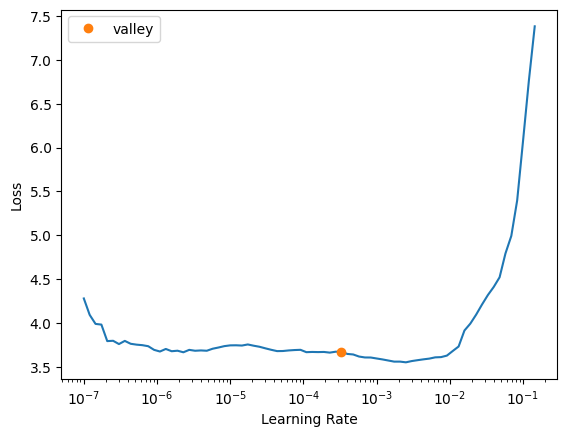

In [98]:
learn.lr_find()

In [104]:
learn.fit_one_cycle(1, 3e-4)

epoch,train_loss,valid_loss,perplexity,time
0,3.160623,3.535712,34.319435,00:35


In [105]:
prompt = 'And when they call you the answer, you are hardly questioned'
input_ids = tokenizer.encode(prompt, return_tensors='pt').to('cuda')

In [106]:
print('Generating...')
preds = learn.model.generate(
    input_ids,
    min_length=200,
    max_length=1000,
    num_beams=5,
    do_sample=True,
    temperature=1.1,
    repetition_penalty=10.0,
    early_stopping=True,
    pad_token_id=tokenizer.eos_token_id
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0], skip_special_tokens=True))

Generating...
Output:
----------------------------------------------------------------------------------------------------
And when they call you the answer, you are hardly questioned
You don't even need to ask for a reply


I'm not scared of what I say 'til it's too late
'Cause we're all so different in this world
It's only me and my motherfucking niggas that have been here before us
This shit is just going on right now
My momma told me she'd be back at some point soon
She said her baby would come home by then
That was years ago (Ayy)
But no one ever came up until now
No one ever came up until now
Oh well, good luck with your decision tonight
Yours best friend will miss ya if he doesn't see ya next time
Nigga, nigga, lookin' like our new friends
Yeah, y'all ain't gotta know about somethin' goin' down
Takin' money from other girls who wanna put lipstick on someone else's face
Uh, yeah, uh-huh? What am I supposed to do tomorrow?
What am I supposed to do every single day?
Whoa, houstatla

In [107]:
# Let's try a longer prompt
prompt = '''Bun B, king of the trill, also one of the dopest
Whether the streets or on the mic, I'm dope and yes I'm focused
The gangsta recognize me for my loc-ness, no joke, it's
Time to shake these haters off like the skin of a locust
Or maybe like a python, that's the type of shit I'm on'''
input_ids = tokenizer.encode(prompt, return_tensors='pt').to('cuda')

In [111]:
print('Generating with a longer prompt...')
preds = learn.model.generate(
    input_ids,
    min_length=200,
    max_length=1000,
    num_beams=5,
    do_sample=True,
    temperature=0.5,
    repetition_penalty=10.0,
    early_stopping=True,
    pad_token_id=tokenizer.eos_token_id
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0], skip_special_tokens=True))

Generating with a longer prompt...
Output:
----------------------------------------------------------------------------------------------------
Bun B, king of the trill, also one of the dopest 
Whether the streets or on the mic, I'm dope and yes I'm focused
The gangsta recognize me for my loc-ness, no joke, it's
Time to shake these haters off like the skin of a locust
Or maybe like a python, that's the type of shit I'm on
I don't really know what you're sayin' 'bout right now


Ayy, niggas gettin' too excited when they see us in action
They think we gon' take some shots at them nigga (Nigga)
We ain't even gotta worry about who our next target will be
It's all just nothin' out of this world so far from real
You can tell by how your heart is still beatin'
And if there's anything wrong with y'all’s attitude then go fuck yourself
That'll only make things more complicated
So tryna do better than let someone else live up to their expectations
Just keep watchin' every single time somebody doe

In [115]:
# See if the model is able to gain more context through a prompt with a storyline
prompt = '''Now I ain't sayin' you a gold digger, you got needs
You don't want a dude to smoke, he can't buy weed
You go out to eat, he can't pay, y'all can't leave
There's dishes in the back, he gotta roll up his sleeves
But while y'all washin', watch him
He gon' make it to a Benz out of that Datsun

He got that ambition, baby, look at his eyes
This week he moppin' floors, next week it's the fries
So, stick by his side
I know there's dudes ballin', and yeah, that's nice
And y'all gon' keep callin' and tryin'
But you stay right girl
And when he get on, he'll leave yo' ass for a white girl'''

input_ids = tokenizer.encode(prompt, return_tensors='pt').to('cuda')

In [124]:
print('Generating with a storyline prompt...')
preds = learn.model.generate(
    input_ids,
    min_length=500,
    max_length=1000,
    num_beams=5,
    do_sample=True,
    temperature=0.3,
    repetition_penalty=50.0,
    early_stopping=True,
    pad_token_id=tokenizer.eos_token_id
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0], skip_special_tokens=True))

Generating with a storyline prompt...
Output:
----------------------------------------------------------------------------------------------------
Now I ain't sayin' you a gold digger, you got needs
You don't want a dude to smoke, he can't buy weed
You go out to eat, he can't pay, y'all can't leave
There's dishes in the back, he gotta roll up his sleeves
But while y'all washin', watch him
He gon' make it to a Benz out of that Datsun

He got that ambition, baby, look at his eyes
This week he moppin' floors, next week it's the fries
So, stick by his side
I know there's dudes ballin', and yeah, that's nice
And y'all gon' keep callin' and tryin'
But you stay right girl
And when he get on, he'll leave yo' a- for a white girl


Yeah (Ayy), she love me so much more than we ever could have been together
She just wanna be friends with my old niggas who used to hang around 'cause they'd never see each other again
They had no choice but to let her fuck them assholes like Jodeci or Giorgio Armani


In [132]:
print('Generating with a storyline prompt...')
preds = learn.model.generate(
    input_ids,
    min_length=200,
    max_length=1000,
    num_beams=3,
    do_sample=True,
    temperature=0.3,
    repetition_penalty=20.0,
    early_stopping=True,
    pad_token_id=tokenizer.eos_token_id
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0], skip_special_tokens=True))

Generating with a storyline prompt...
Output:
----------------------------------------------------------------------------------------------------
Now I ain't sayin' you a gold digger, you got needs
You don't want a dude to smoke, he can't buy weed
You go out to eat, he can't pay, y'all can't leave
There's dishes in the back, he gotta roll up his sleeves
But while y'all washin', watch him
He gon' make it to a Benz out of that Datsun

He got that ambition, baby, look at his eyes
This week he moppin' floors, next week it's the fries
So, stick by his side
I know there's dudes ballin', and yeah, that's nice
And y'all gon' keep callin' and tryin'
But you stay right girl
And when he get on, he'll leave yo' a- for a white girl
She just wanna be with her friends


Yeah, she love me so much more than we ever could have been together
We never really talked about what was going through my mind
It feels like every single time they talk 'bout who is this nigga from?
They always ask how old are thes